In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

class DTWVisualizer:
    """
    Diese Klasse kümmert sich um die Darstellung. 
    Du musst dich hier nicht reindenken, nutze sie einfach als Werkzeug.
    """
    def __init__(self, audio_seq, score_seq):
        self.audio = audio_seq
        self.score = score_seq
        self.fig = plt.figure(figsize=(14, 8))
        self.grid = plt.GridSpec(2, 3, height_ratios=[1, 3], width_ratios=[3, 1, 0.1])
        
        # Style
        sns.set_theme(style="white")
        
    def plot_signals(self):
        """Zeichnet die beiden Signale an die Ränder der Matrix."""
        # Oben: Die Partitur (Score)
        ax_score = self.fig.add_subplot(self.grid[0, 0])
        ax_score.plot(self.score, color='green', marker='o', linestyle='-', markersize=4, label='Partitur (Referenz)')
        ax_score.set_xlim(0, len(self.score)-1)
        ax_score.legend()
        ax_score.set_title("Referenz (X-Achse)")
        ax_score.set_xticks([]) # Keine Ticks für saubereren Look
        
        # Rechts: Das Audio (Live Input)
        # Wir drehen es, damit es zur Y-Achse der Matrix passt
        ax_audio = self.fig.add_subplot(self.grid[1, 1])
        ax_audio.plot(self.audio, np.arange(len(self.audio)), color='purple', marker='x', linestyle='-', markersize=4, label='Audio (Live)')
        ax_audio.set_ylim(len(self.audio)-1, 0) # Invertieren, damit 0 oben ist (wie Matrix)
        ax_audio.legend()
        ax_audio.set_title("Live Input (Y-Achse)")
        ax_audio.set_yticks([])

    def plot_matrix(self, matrix, path=None, title="Kosten-Matrix", log_scale=False):
        """
        Zeichnet die Matrix in die Mitte.
        :param matrix: 2D numpy array (Die Kosten)
        :param path: Liste von Tupeln [(row, col), ...] für den optimalen Weg
        :param title: Überschrift
        :param log_scale: Falls True, werden Farben logarithmisch skaliert (gut für HMM/hohe Kosten)
        """
        ax_matrix = self.fig.add_subplot(self.grid[1, 0])
        
        # Heatmap zeichnen
        norm = LogNorm() if log_scale else None
        sns.heatmap(matrix, cmap="viridis", ax=ax_matrix, cbar=False, norm=norm,
                    xticklabels=False, yticklabels=False, annot=True)
        
        # Pfad einzeichnen (falls vorhanden)
        if path is not None:
            # Pfad entpacken: zip(*path) macht aus [(x,y), (x2,y2)] -> ([x, x2], [y, y2])
            rows, cols = zip(*path)
            # +0.5 damit die Linie genau durch die Mitte der Pixel geht
            ax_matrix.plot(np.array(cols) + 0.5, np.array(rows) + 0.5, color='red', linewidth=3, alpha=0.8, label='Optimaler Pfad')
            ax_matrix.scatter(np.array(cols) + 0.5, np.array(rows) + 0.5, color='white', s=20)
            ax_matrix.legend()

        ax_matrix.set_xlabel("Partitur Frame Index")
        ax_matrix.set_ylabel("Audio Frame Index")
        ax_matrix.set_title(title)

    def show(self):
        plt.tight_layout()
        plt.show()

# ---------------------------------------------------------

class DTWEngine:
    """
    DEIN ARBEITSPLATZ.
    Hier simulierst du den Mikrocontroller.
    """
    def __init__(self, reference_score):
        self.score = reference_score
        self.n_score = len(reference_score)
        
    def compute_offline_dtw(self, live_audio):
        """
        Berechnet die klassische DTW Matrix (Offline).
        Das ist deine Referenz, um zu sehen, wie es "perfekt" aussehen würde.
        """
        n_audio = len(live_audio)
        
        # 1. Initialisierung (Unendlich)
        accumulated_cost = np.full((n_audio, self.n_score), np.inf)
        
        # Startpunkt (0,0) ist Kosten 0
        # Wir müssen hier manuell den ersten Wert setzen
        accumulated_cost[0, 0] = abs(live_audio[0] - self.score[0])

        # 2. Durchlaufen (Der Loop, der auf dem Teensy läuft)
        for i in range(n_audio): # Zeilen (Audio / Zeit)
            for j in range(self.n_score): # Spalten (Partitur)
                
                # Lokale Distanz (Hier einfach Differenz, später Chroma-Vektor Distanz)
                dist = abs(live_audio[i] - self.score[j])
                
                if i == 0 and j == 0:
                    continue # Haben wir oben schon gesetzt
                
                # Die drei Nachbarn holen (mit Boundary Check)
                cost_diag = accumulated_cost[i-1, j-1] if (i>0 and j>0) else np.inf
                cost_top  = accumulated_cost[i-1, j]   if (i>0)       else np.inf
                cost_left = accumulated_cost[i, j-1]   if (j>0)       else np.inf
                
                # HIER KANNST DU EXPERIMENTIEREN:
                # Füge Slope Constraints (Strafen) hinzu
                penalty_diag = 0.0
                penalty_top  = 1.0  # Strafe fürs Warten
                penalty_left = 1.0  # Strafe fürs Skippen (Horizontale Bewegung ist im ODTW eigentlich nicht möglich, hier aber schon)

                # Die Entscheidung (Minimum + Lokal)
                accumulated_cost[i, j] = dist + min(
                    cost_diag + penalty_diag,
                    cost_top  + penalty_top,
                    cost_left + penalty_left
                )

        return accumulated_cost

    def backtrack_path(self, cost_matrix):
        """
        Findet den roten Pfad rückwärts (Backtracking).
        """
        i, j = cost_matrix.shape[0] - 1, cost_matrix.shape[1] - 1
        path = [(i, j)]
        while i > 0 or j > 0:
            # Nachbarn prüfen
            vals = []
            moves = []
            
            if i > 0 and j > 0: 
                vals.append(cost_matrix[i-1, j-1])
                moves.append((-1, -1)) # Diagonal
            if i > 0:           
                vals.append(cost_matrix[i-1, j])
                moves.append((-1, 0))  # Oben
            if j > 0:           
                vals.append(cost_matrix[i, j-1])
                moves.append((0, -1))  # Links
                
            # Besten Weg wählen
            best_idx = np.argmin(vals)
            di, dj = moves[best_idx]
            i += di
            j += dj
            path.append((i, j))
            
        return path[::-1] # Umdrehen

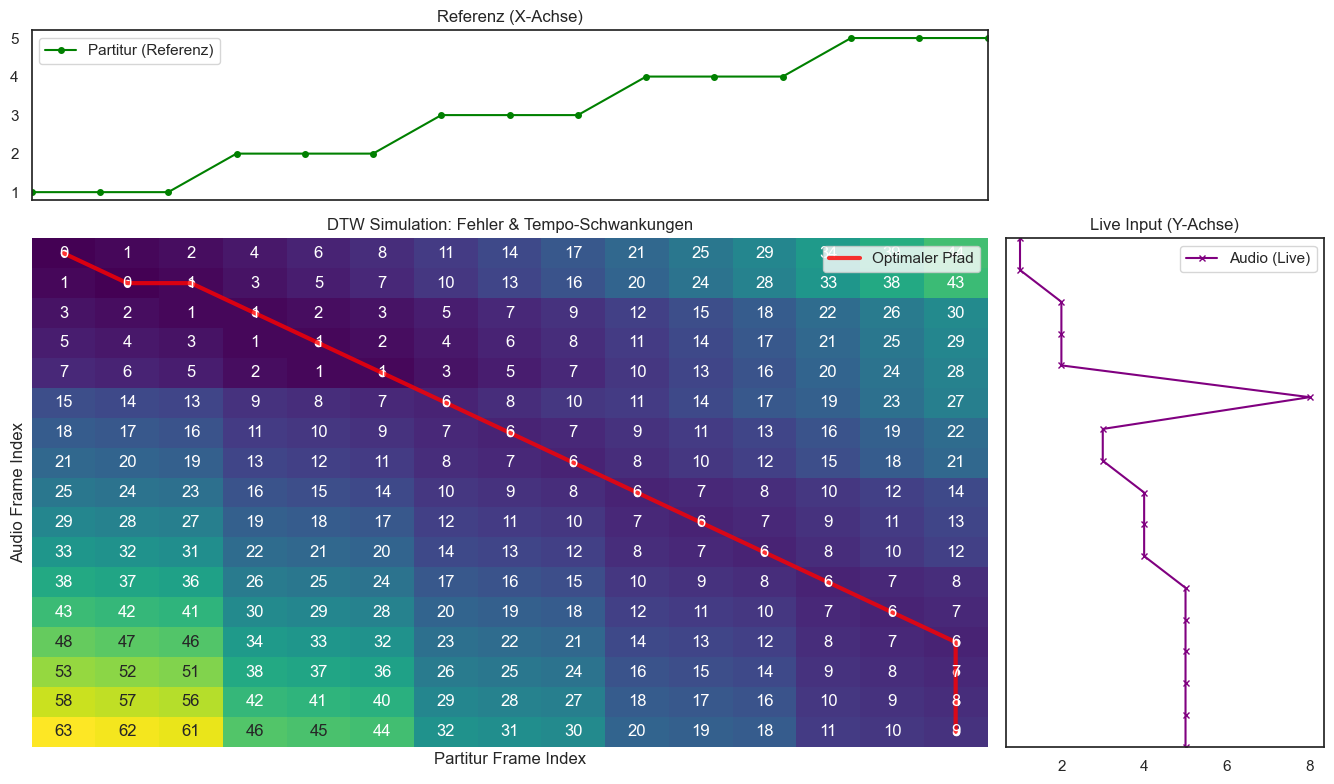

In [2]:
# ==========================================
# DEIN LABOR (Main Script)
# ==========================================

# 1. Daten Erstellen (Synthetisch)
# Partitur: Einfache Tonleiter (Zahlen stehen für Tonhöhe)
partitur = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]

# Audio: Der Musiker spielt die Töne, aber mit Fehlern!
# Szenario: Er spielt am Anfang schneller (nur 2x die 1), 
# macht bei der 3 einen Fehler (spielt 8 statt 3 -> Husten),
# und trödelt am Ende bei der 5.
audio_aufnahme = [1, 1, 2, 2, 2, 8, 3, 3, 4, 4, 4, 5, 5, 5, 5, 5, 5] 

# 2. Engine starten
engine = DTWEngine(partitur)

# 3. Berechnen (Das macht der Teensy intern)
# Wir nutzen hier simple 1D-Distanzen (Zahlen-Differenz). 
# Später kannst du Chroma-Vektoren nutzen.
matrix = engine.compute_offline_dtw(audio_aufnahme)
pfad = engine.backtrack_path(matrix)

# 4. Visualisierung (Der einfache Teil dank Framework)
gui = DTWVisualizer(audio_aufnahme, partitur)
gui.plot_signals()
gui.plot_matrix(matrix, path=pfad, title="DTW Simulation: Fehler & Tempo-Schwankungen")
gui.show()

In [3]:
# ==========================================
# TEIL 1: Die Teensy-Logik (Die Klasse)
# ==========================================

class RealTimeDTW:
    def __init__(self, reference_score):
        """
        Setup (das passiert im 'void setup()')
        """
        self.score = reference_score
        self.N = len(reference_score)
        
        # Auf dem Teensy sind das zwei Arrays der Länge N
        # Wir initialisieren sie mit "Unendlich", weil wir noch nirgendwo waren.
        self.previous_column = np.full(self.N, np.inf)
        
        # Startbedingung: Wir fangen sicher beim ersten Ton (Index 0) an.
        self.previous_column[0] = 0.0 
        
        # Nur für die spätere Grafik (Auf dem Teensy speichern wir das NICHT!)
        self.history_for_plotting = [] 
        self.history_for_plotting.append(self.previous_column.copy())

    def loop(self, live_input_value):
        current_column = np.full(self.N, np.inf)
        
        for j in range(self.N): 
            # 1. Distanz messen
            dist = abs(live_input_value - self.score[j])
            
            # 2. Transitionen prüfen (Woher kommen wir?)
            
            # A. Warten (Self) -> Musiker ist langsam
            cost_wait = self.previous_column[j]
            
            # B. Schritt (Next) -> Musiker ist normal
            if j > 0:
                cost_step = self.previous_column[j-1]
            else:
                cost_step = np.inf
                
            # C. Sprung (Skip) -> Musiker ist SCHNELL!
            # Wir schauen ZWEI Schritte zurück (j-2)
            if j > 1:
                cost_skip = self.previous_column[j-2]
            else:
                cost_skip = np.inf

            # 3. Strafen (Das Tuning)
            penalty_wait = 2  # Strafe fürs Trödeln
            penalty_step = 0.0  # Normales Tempo ist gratis
            
            # HIER IST DER TRICK:
            # Wir machen den Sprung nur ein BISSCHEN teurer als den normalen Schritt.
            # Wenn der Sound bei j (Skip) viel besser passt als bei j-1 (Schritt),
            # wird er diese Option wählen, trotz der kleinen Strafe.
            penalty_skip = 0.8 

            # 4. Minimum finden (Jetzt aus 3 Optionen!)
            min_prev_cost = min(
                cost_wait + penalty_wait, 
                cost_step + penalty_step,
                cost_skip + penalty_skip
            )
            
            current_column[j] = dist + min_prev_cost

        self.previous_column = current_column.copy()
        estimated_position = np.argmin(current_column)
        self.history_for_plotting.append(current_column)
        
        return estimated_position

--- Start Live Simulation ---
Audio Frame 0 (Wert 10) -> Partitur Stelle 0
Audio Frame 1 (Wert 20) -> Partitur Stelle 1
Audio Frame 2 (Wert 99) -> Partitur Stelle 3
Audio Frame 3 (Wert 99) -> Partitur Stelle 7
Audio Frame 4 (Wert 99) -> Partitur Stelle 7
Audio Frame 5 (Wert 60) -> Partitur Stelle 7
Audio Frame 6 (Wert 70) -> Partitur Stelle 6
Audio Frame 7 (Wert 80) -> Partitur Stelle 7


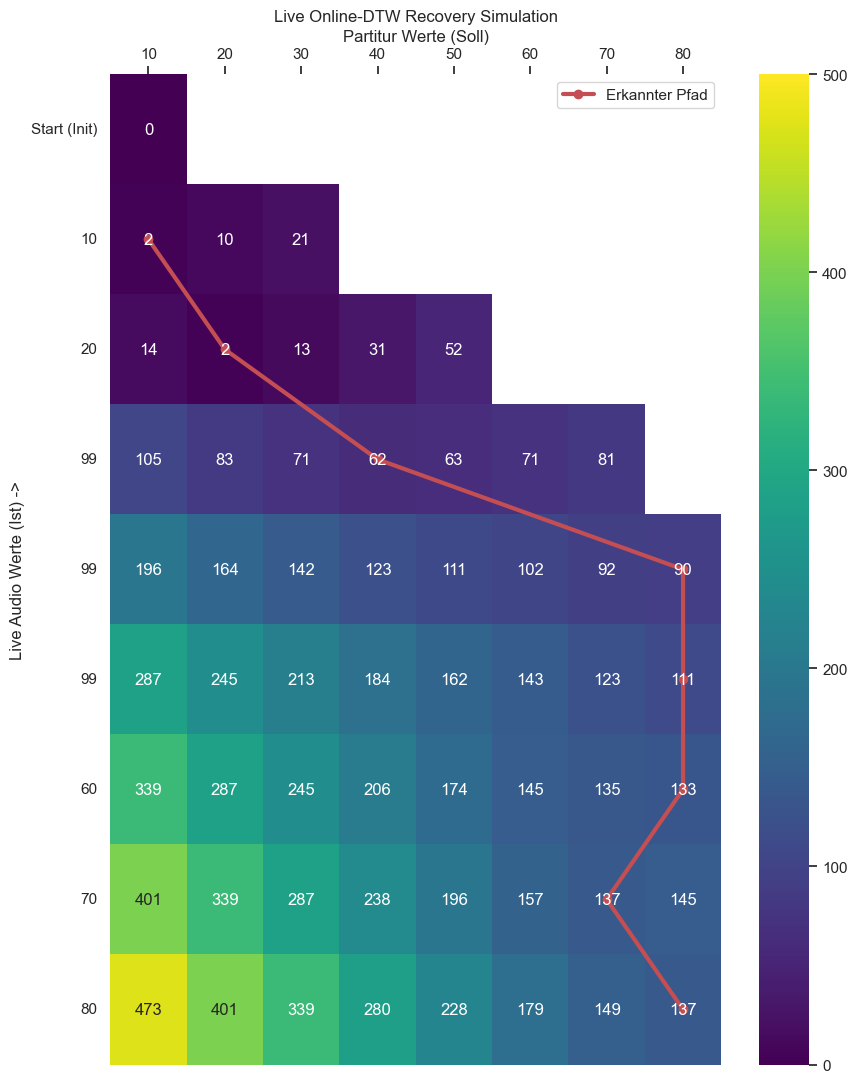

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 2. Simulation Daten
# ==========================================
partitur = [10, 20, 30, 40, 50, 60, 70, 80]

# Das Audio Szenario (Fehler in der Mitte)
live_stream = [10, 20, 99, 99, 99, 60, 70, 80]

# Start
teensy = RealTimeDTW(partitur)
positions_log = []

print("--- Start Live Simulation ---")
for t, sample in enumerate(live_stream):
    pos = teensy.loop(sample)
    positions_log.append(pos)
    print(f"Audio Frame {t} (Wert {sample}) -> Partitur Stelle {pos}")

# ==========================================
# TEIL 3: Grafik (Angepasst)
# ==========================================

full_matrix = np.array(teensy.history_for_plotting)

plt.figure(figsize=(9, 11)) 

# Labels vorbereiten
x_labels = partitur
# Wir fügen "Start" hinzu, weil die Matrix eine Zeile mehr hat als das Audio
y_labels = ["Start (Init)"] + live_stream 

# Heatmap zeichnen mit festen Grenzen und Labels
sns.heatmap(full_matrix, 
            cmap="viridis", 
            annot=True, 
            fmt=".0f",      # Keine Nachkommastellen für Übersichtlichkeit
            cbar=True, 
            vmin=0,         # Start bei 0
            vmax=500,       # Ende bei 500 (wie gewünscht)
            xticklabels=x_labels, # Echte Werte statt Indizes
            yticklabels=y_labels  # Echte Werte statt Indizes
            )

# Pfad einzeichnen
x_coords = np.array(positions_log) + 0.5
y_coords = np.arange(len(live_stream) + 1) + 0.5 

plt.plot(x_coords, y_coords[1:], 'r-o', linewidth=3, label="Erkannter Pfad")

# Achsenbeschriftung oben platzieren
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.xticks(rotation=0) # Damit die Zahlen oben gerade stehen
plt.yticks(rotation=0) # Damit die Zahlen links gerade stehen

plt.xlabel("Partitur Werte (Soll)")
plt.ylabel("Live Audio Werte (Ist) ->")
plt.title("Live Online-DTW Recovery Simulation")
plt.legend()
plt.tight_layout()
plt.show()